In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, StateStore, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2

## Load cluster run

In [3]:
run_name = "mild-valley-11"  # wandb run name

In [4]:
config_file = "../logging/cosmology/{}/config.yaml".format(run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [5]:
print("{} devices visible".format(jax.device_count()))

# Load the dataset
train_ds = load_data(config.data.dataset, config.data.n_features, config.data.n_particles, config.training.batch_size, config.seed, **config.data.kwargs)
batches = create_input_iter(train_ds)

# VDM and Transformer score model configuration
transformer_dict = FrozenDict({"d_model": config.transformer.d_model, "d_mlp": config.transformer.d_mlp, "n_layers": config.transformer.n_transformer_layers, "n_heads": config.transformer.n_heads, "induced_attention": config.transformer.induced_attention, "n_inducing_points": config.transformer.n_inducing_points})
vdm = VariationalDiffusionModel(n_layers=config.vdm.n_encoder_layers, d_embedding=config.vdm.d_embedding, d_hidden_encoding=config.vdm.d_hidden_encoding, timesteps=config.vdm.timesteps, d_feature=config.data.n_features, transformer_dict=transformer_dict, embed_context=config.vdm.embed_context, n_classes=config.vdm.n_classes)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

4 devices visible
Params: 6,474,097


In [6]:
ckpt_dir = "../logging/cosmology/{}/".format(run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state)

## Load data

In [9]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"
logging_dir = "/n/holystore01/LABS/iaifi_lab/Users/smsharma/set-diffuser/logging/"

In [10]:
n_particles = 5000
n_features = 3

# Load and normalize
x = np.load("{}/halos.npy".format(data_dir))

# x = x.at[:, :, -1].set(np.log10(x[:, :, -1]))

x_mean = x.mean(axis=(0,1))
x_std = x.std(axis=(0,1))
x = (x - x_mean + 1e-7) / (x_std + 1e-7)

x = x[:, :n_particles, :n_features]
conditioning = np.array(pd.read_csv("{}/cosmology.csv".format(data_dir)).values)
mask = np.ones((x.shape[0], n_particles))

## Evaluate simulations

In [11]:
n_samples = 8
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=cond_gen, mask=mask_gen)
x_samples = x_samples.mean()

Text(0.5, 0, 'z')

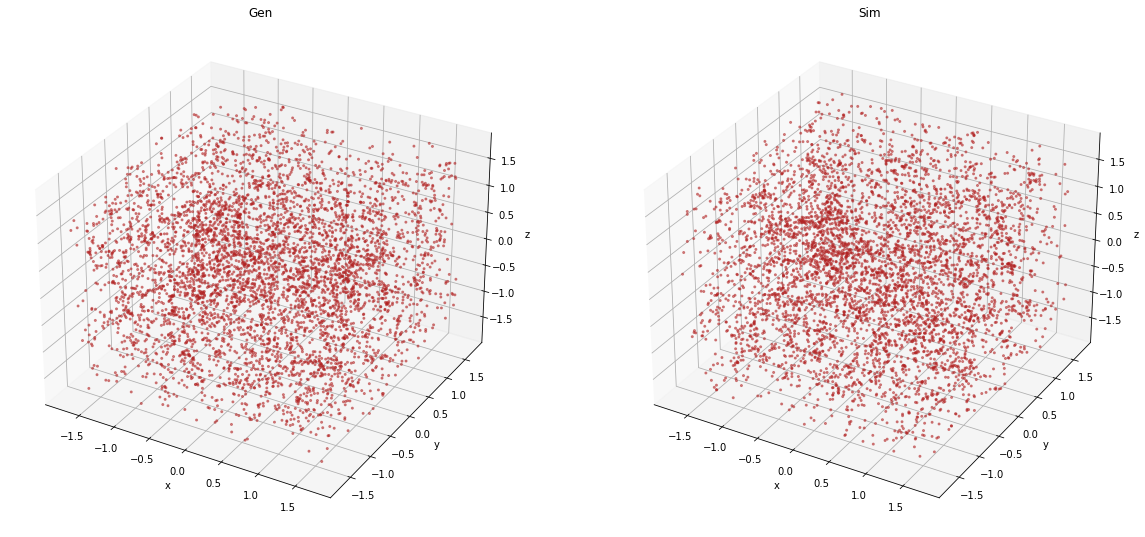

In [12]:
idx = 0

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

In [13]:
x_rnd = jax.random.uniform(rng, shape=x[idx_rnd[idx], :config.data.n_particles, :config.data.n_features].shape, minval=0, maxval=1000)

Text(0, 0.5, 'y')

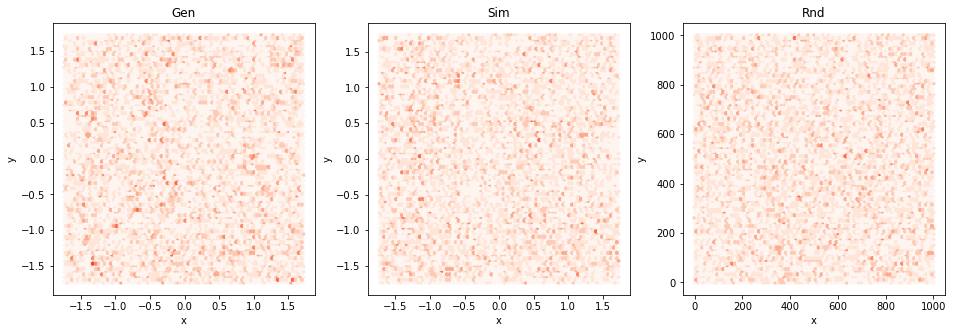

In [14]:
s = 4
alpha = 0.5
color = "firebrick"
gs = 80
cmap = "Reds"

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

vmin=0
vmax=10

ax1.hexbin(x_samples[idx, :, 0], x_samples[idx, :, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.hexbin(x[idx, :config.data.n_particles, 0], x[idx_rnd[idx], :config.data.n_particles, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

ax3.hexbin(x_rnd[:config.data.n_particles, 0], x_rnd[:config.data.n_particles, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title("Rnd")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

In [15]:
sys.path.append("../../ili-summarizer/")
sys.path.append("../../ili-summarizer/summarizer/")

from knn.knn import KNN
from data.catalogue import Catalogue

In [16]:
r_bins = np.linspace(0, 100, 100)
k = np.arange(1, 10)
knn = KNN(r_bins, k)

Text(0.5, 1.0, 'KNN')

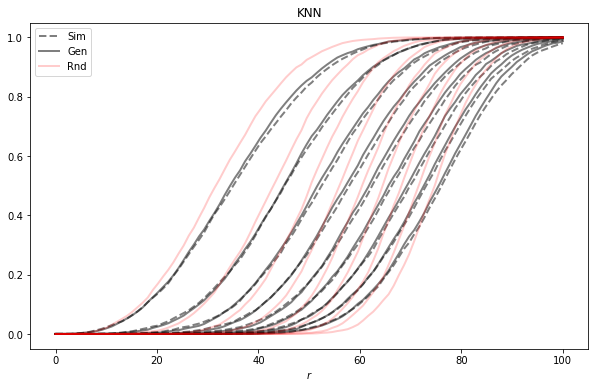

In [17]:
plt.figure(figsize=(10, 6))

cat = Catalogue(pos=x[idx_rnd[idx], :config.data.n_particles, :config.data.n_features] * x_std[:config.data.n_features] + x_mean[:config.data.n_features], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
knn_res = knn(cat)

for i in range(len(knn_res)):
    plt.plot(r_bins, knn_res[i], color='k', ls='--', alpha=0.5, lw=2, label="Sim" if i == 0 else None)
    
cat = Catalogue(pos=x_samples[idx] * x_std[:config.data.n_features] + x_mean[:config.data.n_features], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
knn_res = knn(cat)

for i in range(len(knn_res)):
    plt.plot(r_bins, knn_res[i], color='k', ls='-', alpha=0.5, lw=2, label="Gen" if i == 0 else None)
       
cat = Catalogue(pos=x_rnd, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
knn_res = knn(cat)

for i in range(len(knn_res)):
    plt.plot(r_bins, knn_res[i], color='red', ls='-', alpha=0.2, lw=2, label="Rnd" if i == 0 else None)
    
plt.xlabel("$r$")

plt.legend()
plt.title("KNN")

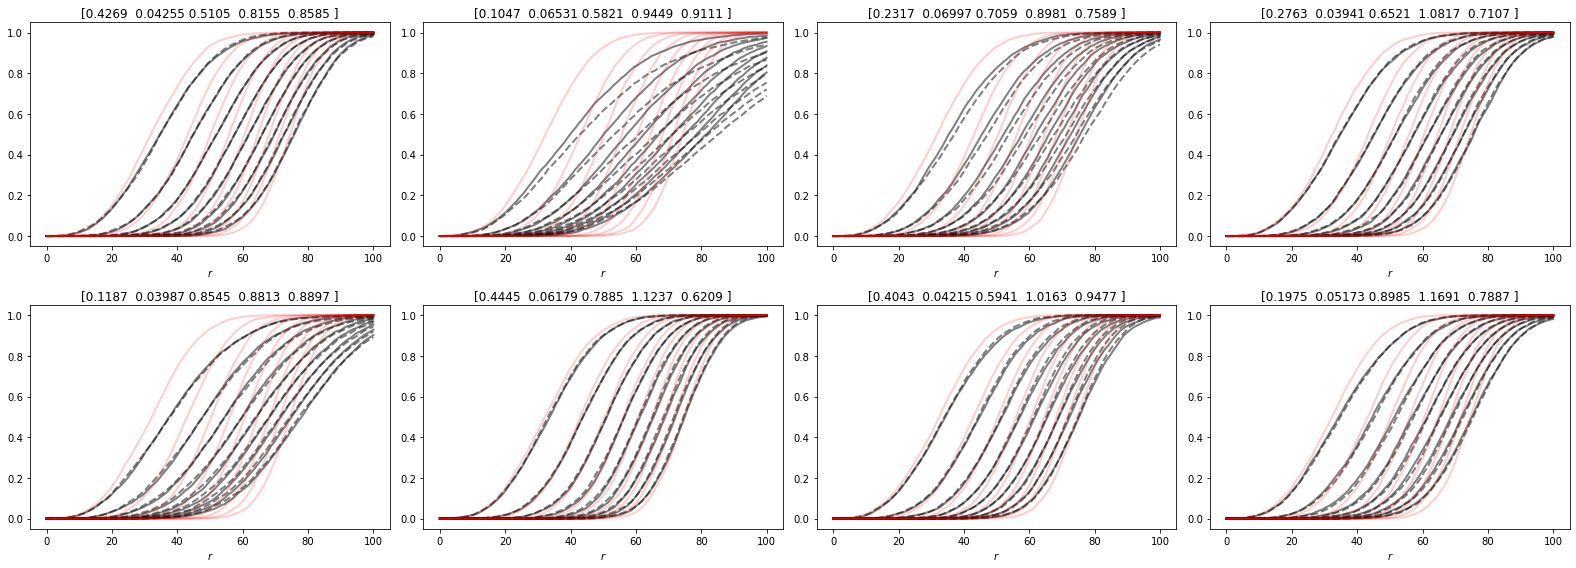

In [18]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(22, 8))
gs = GridSpec(2, 4)

for idx in range(8):
    
    ax = fig.add_subplot(gs[idx])
    
    cat = Catalogue(pos=x[idx_rnd[idx], :config.data.n_particles, :config.data.n_features] * x_std[:config.data.n_features] + x_mean[:config.data.n_features], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        ax.plot(r_bins, knn_res[i], color='k', ls='--', alpha=0.5, lw=2, label="Sim" if i == 0 else None)

    cat = Catalogue(pos=x_samples[idx] * x_std[:config.data.n_features] + x_mean[:config.data.n_features], vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        ax.plot(r_bins, knn_res[i], color='k', ls='-', alpha=0.5, lw=2, label="Gen" if i == 0 else None)

    cat = Catalogue(pos=x_rnd, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        ax.plot(r_bins, knn_res[i], color='red', ls='-', alpha=0.2, lw=2, label="Rnd" if i == 0 else None)

    ax.set_xlabel("$r$")

    ax.set_title(conditioning[idx_rnd[idx]])

plt.tight_layout()

## Different cosmologies

In [19]:
from einops import repeat

n_lin = 21

conditioning_mean = np.mean(conditioning, axis=0)
conditioning_batch = repeat(conditioning_mean, "c -> c n", n=n_lin)

In [20]:
conditioning_batch = conditioning_batch.at[0].set(np.linspace(0.1, 0.5, n_lin)).T

In [23]:
x_samples_cond = [generate(vdm, restored_state.params, rng, (1, n_particles), conditioning=conditioning_batch[i][None, :], mask=mask_gen[0][None, :]) for i in tqdm(range(n_lin))]
x_samples_cond = np.array([xx.mean()[0] for xx in x_samples_cond])

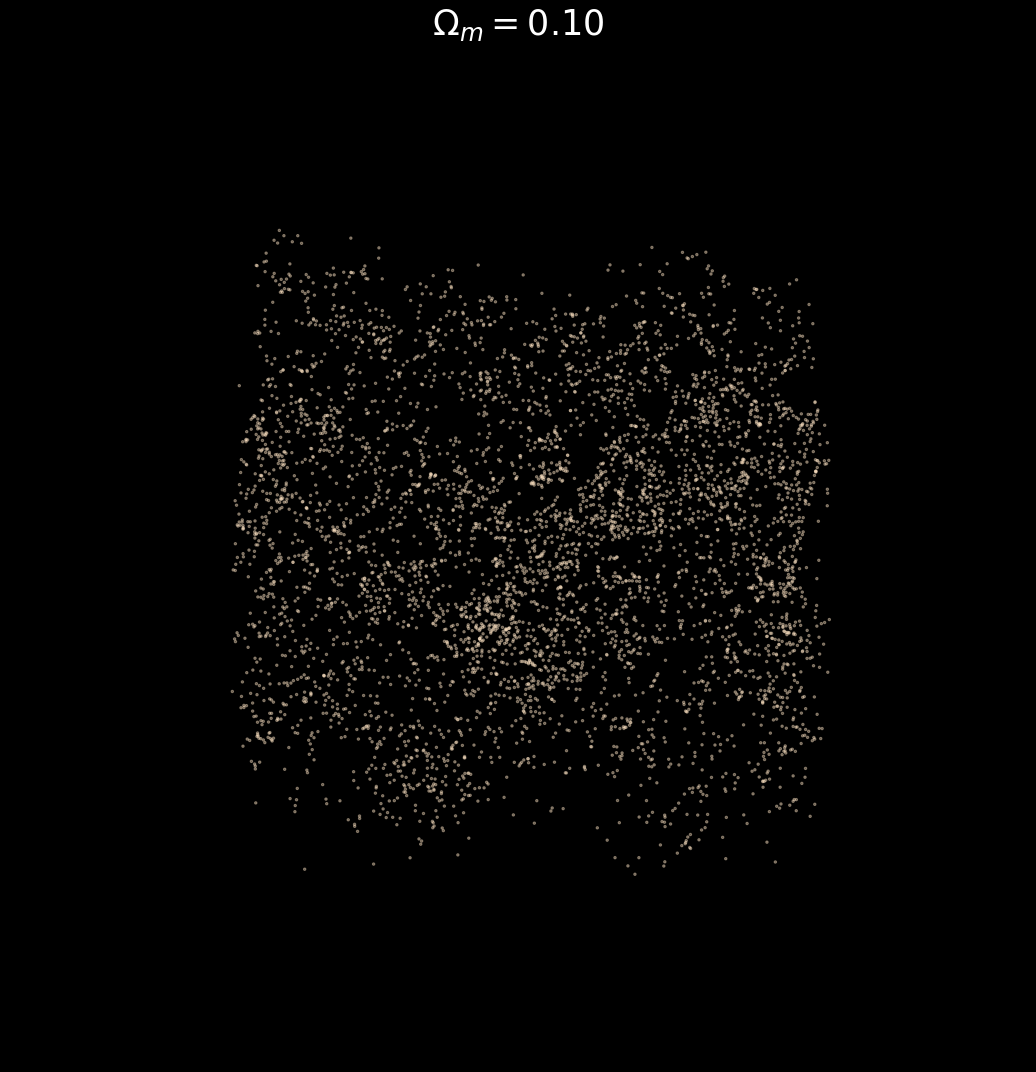

In [221]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib

plt.style.use('dark_background')

fig = plt.figure(figsize=(15, 15))

# ax1 = fig.add_subplot(2, 1, 1, adjustable='box', aspect=0.1)
ax2 = fig.add_subplot(1, 1, 1, projection='3d')

def update(frame, idx_array, angle_array, rotate=True):
    
    # ax1.clear()
    ax2.clear()
    
    ii = idx_array[frame]
    
    if rotate:
        ax2.view_init(30, angle_array[frame])
    
    x_plot = x_samples_cond[ii] * x_std + x_mean
    ax2.scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.4, s=6, color="bisque");
    
    ax2.set_title(r"$\Omega_m = {:.2f}$".format(round(conditioning_batch[ii, 0], 2)), fontsize=35)
    
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("z")
    
    ax2.set_axis_off()
    
    plt.tight_layout()


array = np.arange(n_lin)
index = 0
increment = 1

n_frames = 10 * n_lin  # 10 breaths

idx_array = []
for i in range(n_frames):
    idx_array.append(array[index])
    
    if index == len(array) - 1:
        increment = -1
    elif index == 0:
        increment = 1
        
    index += increment
    
idx_array = np.array(idx_array)

repeat_ary = np.ones_like(idx_array)
repeat_ary = repeat_ary.at[np.concatenate([np.where(idx_array == 0)[0], np.where(idx_array == n_lin - 1)[0]])].set(5)  # Pause steps
idx_array = np.repeat(idx_array, repeat_ary)

idx_array = np.concatenate([idx_array, np.arange(idx_array[-1], 0, -1)])

angle_array = np.linspace(0, 360, len(idx_array))

rotate = False

ani = animation.FuncAnimation(fig, partial(update, idx_array=idx_array, angle_array=angle_array, rotate=rotate) , frames=len(idx_array), interval=100)
ani.save("animation_norotate.gif", writer="imagemagick")

rotate = True

ani = animation.FuncAnimation(fig, partial(update, idx_array=idx_array, angle_array=angle_array, rotate=rotate) , frames=len(idx_array), interval=100)
ani.save("animation.gif", writer="imagemagick")

## Vary $\Omega_m$ and $\sigma_8$

In [24]:
from einops import repeat

n_lin = 9 * 2

conditioning_mean = np.mean(conditioning, axis=0)
conditioning_batch = repeat(conditioning_mean, "c -> c n", n=n_lin)

In [25]:
conditioning_batch = conditioning_batch.at[-1, :int(n_lin / 2)].set(0.6)
conditioning_batch = conditioning_batch.at[0, :int(n_lin / 2)].set(np.linspace(0.1, 0.5, int(n_lin / 2)))
conditioning_batch = conditioning_batch.at[0, int(n_lin / 2):].set(0.5)
conditioning_batch = conditioning_batch.at[-1, int(n_lin / 2):].set(np.linspace(0.6, 1., int(n_lin / 2))).T

In [26]:
conditioning_batch = np.concatenate([conditioning_batch, conditioning_batch[::-1]])

In [27]:
conditioning_batch = conditioning_batch.at[n_lin:, -1].set(1.)
conditioning_batch = conditioning_batch.at[n_lin:n_lin + int(n_lin / 2), 0].set(np.linspace(0.5, 0.1, int(n_lin / 2)))
conditioning_batch = conditioning_batch.at[n_lin + int(n_lin / 2):, 0].set(0.1)
conditioning_batch = conditioning_batch.at[n_lin + int(n_lin / 2):, -1].set(np.linspace(1., 0.6, int(n_lin / 2)))

In [29]:
x_samples_cond = [generate(vdm, restored_state.params, rng, (1, n_particles), conditioning=conditioning_batch[i][None, :], mask=mask[0][None, :]) for i in tqdm(range(n_lin * 2))]
x_samples_cond = np.array([xx.mean()[0] for xx in x_samples_cond])




  0%|                                                           | 0/36 [00:00<?, ?it/s]


  3%|█▍                                                 | 1/36 [00:20<11:53, 20.39s/it]


  6%|██▊                                                | 2/36 [00:39<11:05, 19.59s/it]


  8%|████▎                                              | 3/36 [00:58<10:37, 19.31s/it]


 11%|█████▋                                             | 4/36 [01:17<10:13, 19.16s/it]


  0%|                                                           | 0/21 [04:00<?, ?it/s]



 17%|████████▌                                          | 6/36 [01:55<09:38, 19.29s/it]


 19%|█████████▉                                         | 7/36 [02:15<09:23, 19.42s/it]


 22%|███████████▎                                       | 8/36 [02:34<09:01, 19.34s/it]


 25%|████████████▊                                      | 9/36 [02:53<08:37, 19.17s/it]


 28%|█████████████▉                                    | 10/36 [03:13<08:21, 19.29s/it]


 31%|█

In [83]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib


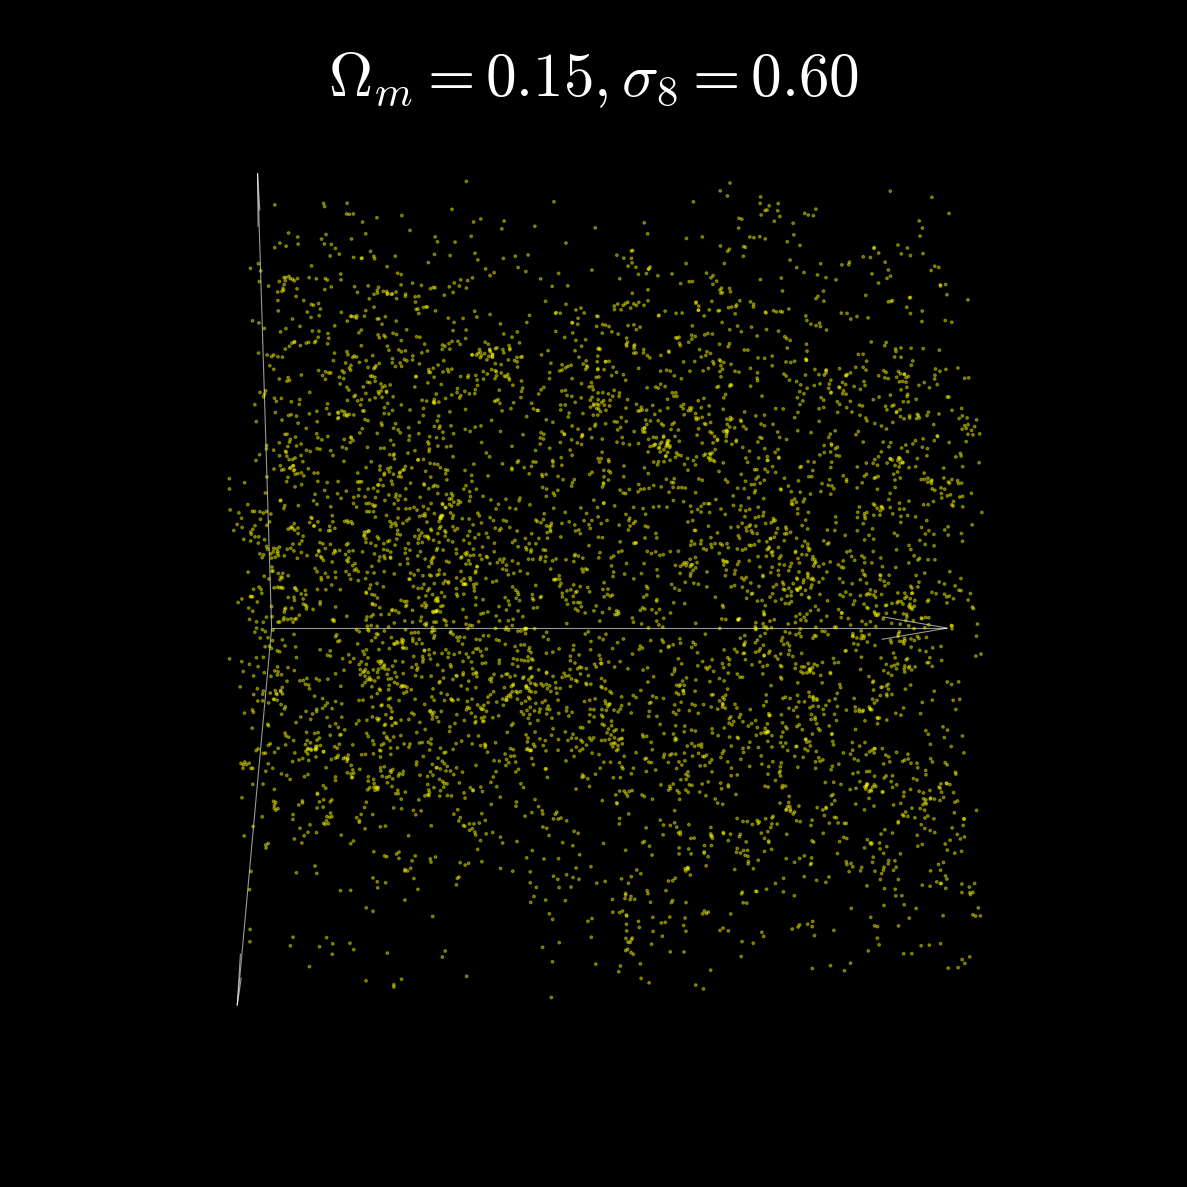

In [91]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(15, 15))

# ax1 = fig.add_subplot(2, 1, 1, adjustable='box', aspect=0.1)
ax2 = fig.add_subplot(1, 1, 1, projection='3d')

def update(frame, idx_array, angle_array, rotate=True):
    
    # ax1.clear()
    ax2.clear()
    
    ii = idx_array[frame]
    
    if rotate:
        ax2.view_init(30, angle_array[frame])
    
    x_plot = x_samples_cond[ii] * x_std[:n_features] + x_mean[:n_features]
    ax2.scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.4, s=6, color="yellow");
    
    ax2.set_title(r"$\Omega_m = {:.2f}, \sigma_8 = {:.2f}$".format(round(conditioning_batch[ii, 0], 2), round(conditioning_batch[ii, -1], 2)), fontsize=55)
    
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("z")
    
    ax2.set_axis_off()
    
    xx, yy, zz = np.zeros((3,3))
    uu, vv, ww = 1000 * np.array([[1,0,0],[0,1,0],[0,0,1]])

    ax2.quiver(xx,yy,zz,uu,vv,ww,arrow_length_ratio=0.1, color='white', alpha=0.6)
    
    ax2.set_xlim(0, 1000)
    ax2.set_ylim(0, 1000)
    ax2.set_zlim(0, 1000)

    plt.tight_layout()


array = np.arange(len(conditioning_batch))
index = 0
increment = 1

n_frames = 4 * len(conditioning_batch)  # 10 breaths

idx_array = []
for i in range(n_frames):
    idx_array.append(array[index])
    
    if index == len(array) - 1:
        increment = -1
    elif index == 0:
        increment = 1
        
    index += increment
    
idx_array = np.array(idx_array)

# repeat_ary = np.ones_like(idx_array)
# repeat_ary = repeat_ary.at[np.concatenate([np.where(idx_array == 0)[0], np.where(idx_array == n_lin - 1)[0]])].set(5)  # Pause steps
# idx_array = np.repeat(idx_array, repeat_ary)

idx_array = np.concatenate([idx_array, np.arange(idx_array[-1], 0, -1)])

angle_array = np.linspace(0, 360, len(idx_array))

rotate = False

ani = animation.FuncAnimation(fig, partial(update, idx_array=idx_array, angle_array=angle_array, rotate=rotate) , frames=len(idx_array), interval=100)
ani.save("animation_both_norotate.gif", writer="imagemagick")

rotate = True

ani = animation.FuncAnimation(fig, partial(update, idx_array=idx_array, angle_array=angle_array, rotate=rotate) , frames=len(idx_array), interval=100)
ani.save("animation_both.gif", writer="imagemagick")

## Animate diffusion process

In [30]:
def generate_timestep(vdm, params, rng, shape, timesteps=1000, conditioning=None, mask=None):
    """Generate samples from a VDM model."""

    # Generate latents
    rng, spl = jax.random.split(rng)
    zt = jax.random.normal(spl, shape + (vdm.d_embedding,))

    def body_fn(i, z_t):
        return vdm.apply(params, rng, i, vdm.timesteps, z_t, conditioning, mask=mask, method=vdm.sample_step)

    z0 = jax.lax.fori_loop(lower=0, upper=timesteps, body_fun=body_fn, init_val=zt)

    g0 = vdm.apply(params, 0.0, method=vdm.gammat)
    var0 = sigma2(g0)
    z0_rescaled = z0 / np.sqrt(1.0 - var0)
    return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)


In [31]:
timesteps_ary = np.arange(0, 1001, 25)

In [33]:
x_samples_timesteps = [generate_timestep(vdm, restored_state.params, rng, (1, n_particles), timesteps=t, conditioning=conditioning_batch[0][None, :], mask=mask[0][None, :]) for t in tqdm(timesteps_ary)]
x_samples_timesteps = np.array([xx.mean()[0] for xx in x_samples_timesteps])


  0%|                                                           | 0/36 [14:32<?, ?it/s]

100%|██████████████████████████████████████████████████| 41/41 [08:02<00:00, 11.77s/it]


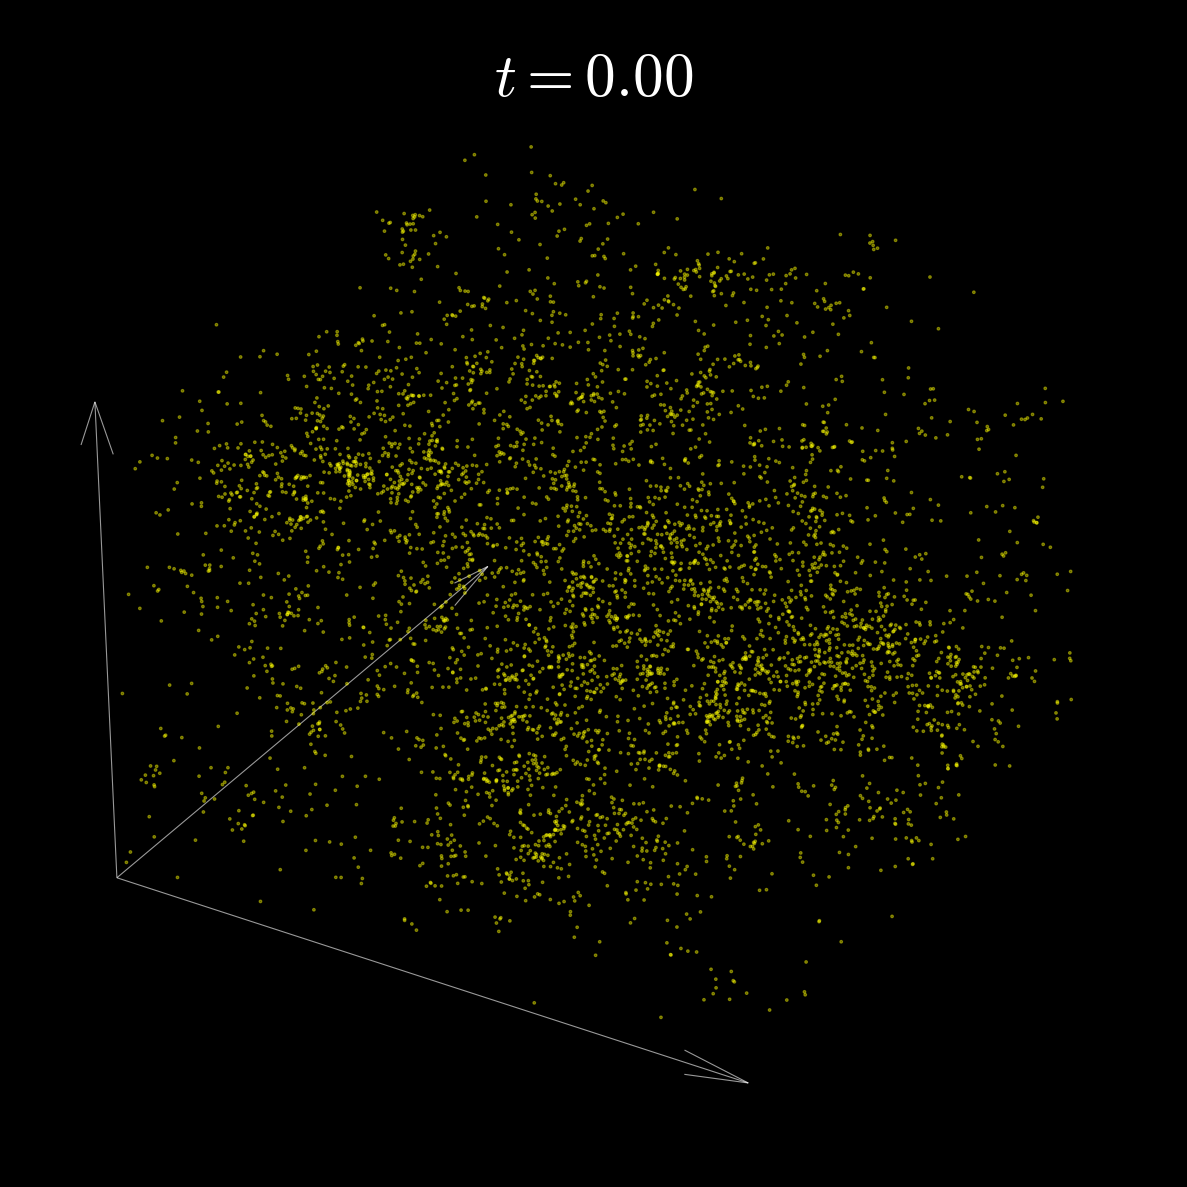

In [92]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(15, 15))

# ax1 = fig.add_subplot(2, 1, 1, adjustable='box', aspect=0.1)
ax2 = fig.add_subplot(1, 1, 1, projection='3d')

def update(frame):
    
    # ax1.clear()
    ax2.clear()
        
    x_plot = x_samples_timesteps[frame] * x_std[:n_features] + x_mean[:n_features]
    ax2.scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.4, s=6, color="yellow");
        
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("z")
    
    ax2.set_title(r"$t = {:.2f}$".format(round(1 - timesteps_ary[frame] / vdm.timesteps, 2)), fontsize=55)

    ax2.set_axis_off()
    
    xx, yy, zz = np.zeros((3,3))
    uu, vv, ww = 1000 * np.array([[1,0,0],[0,1,0],[0,0,1]])

    ax2.quiver(xx,yy,zz,uu,vv,ww,arrow_length_ratio=0.1, color='white', alpha=0.6)
    
    ax2.set_xlim(0, 1000)
    ax2.set_ylim(0, 1000)
    ax2.set_zlim(0, 1000)

    plt.tight_layout()

ani = animation.FuncAnimation(fig, partial(update) , frames=len(x_samples_timesteps), interval=100)
ani.save("animation_diffusion.gif", writer="imagemagick")

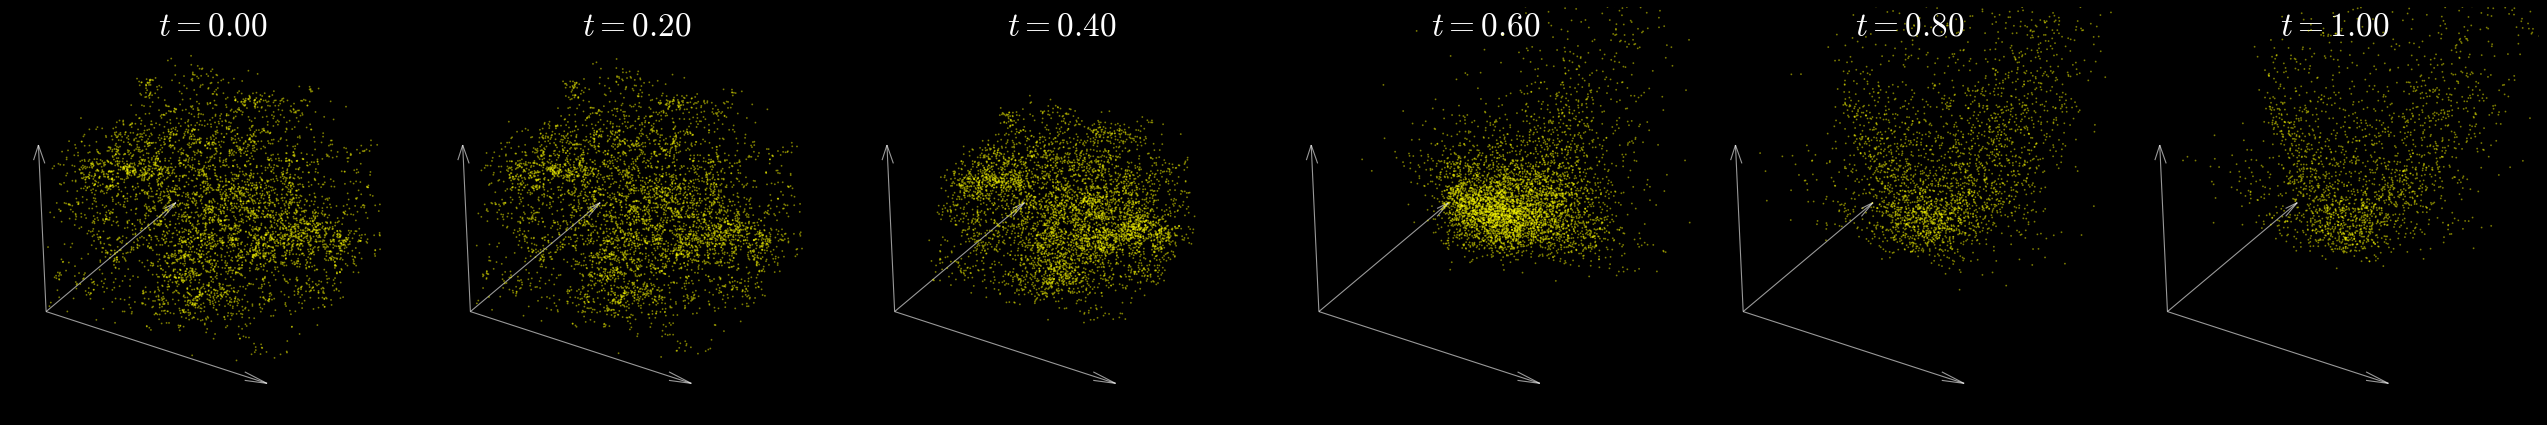

In [81]:
from matplotlib.gridspec import GridSpec

plt.style.use('dark_background')

fig = plt.figure(figsize=(32, 6))

steps_plot = np.arange(0, 41, 8)
gs = GridSpec(1, len(steps_plot))

for idx, i in enumerate(steps_plot[::-1]):
    
    ax = fig.add_subplot(gs[idx], projection='3d')
    ax.clear()
        
    x_plot = x_samples_timesteps[i] * x_std[:n_features] + x_mean[:n_features]
    
    ax.scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.4, s=0.5, color="yellow");
        
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    ax.set_title(r"$t = {:.2f}$".format(round(1 - timesteps_ary[i] / vdm.timesteps, 2)), fontsize=30)

    xx, yy, zz = np.zeros((3,3))
    uu, vv, ww = 1000 * np.array([[1,0,0],[0,1,0],[0,0,1]])

    ax.set_axis_off()

    ax.quiver(xx,yy,zz,uu,vv,ww,arrow_length_ratio=0.1, color='white', alpha=0.6)
    
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 1000)
    ax.set_zlim(0, 1000)
    
plt.tight_layout()

plt.savefig("plots/sequential_nbody.pdf")